In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline

In [3]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_transform, batch_size=64)

In [4]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, latent_size)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 128)
        self.fc2 = nn.Linear(128, 28*28)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.tanh(self.fc2(x))
        return x

In [6]:
class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        self._rho_loss = None
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        self.data_rho = h.mean(0)
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def rho_loss(self, rho, size_average=True):
        """
        D_KL(P||Q) = sum(p*log(p/q)) = -sum(p*log(q/p)) = -p*log(q/p) - (1-p)log((1-q)/(1-p))
        """
        dkl = - torch.log(self.data_rho/rho) * rho - torch.log((1-self.data_rho)/(1-rho)) * (1-rho)
        if size_average:
            self._rho_loss = dkl.mean()
        else:
            self._rho_loss = dkl.sum()
        return self._rho_loss
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [7]:
models = {'16': Net(16), '32': Net(32), '64': Net(64)}
rho = 0.05
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [8]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            rho_loss = model.rho_loss(rho)
            loss = model.loss(output, data) + rho_loss
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._rho_loss))
        print(line + losses)

In [9]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
rho_lambda = lambda p: 'pho_loss: {:.4f}'.format(p)
line = lambda i, l, p: '{}: '.format(i) + avg_lambda(l) + '\t' + rho_lambda(p)
    
def test(models, loader, log=None):
    test_size = len(loader.sampler)


    test_loss = {k: 0. for k in models}
    pho_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, size_average=False).item() # sum up batch loss
                pho_loss[k] += m.rho_loss(rho, size_average=False).item()
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        pho_loss[k] /= (test_size * models[k].latent_size)
        if log is not None:
            log[k].append((test_loss[k], pho_loss[k]))
    
    lines = '\n'.join([line(k, test_loss[k], pho_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [10]:
for epoch in range(1, 21):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses 16: 0.935749 32: 0.942929 64: 0.929205
Train Epoch: 1 [12800/50000 (26%)]	Losses 16: 0.601828 32: 0.506756 64: 0.379914
Train Epoch: 1 [25600/50000 (51%)]	Losses 16: 0.336844 32: 0.310491 64: 0.288035
Train Epoch: 1 [38400/50000 (77%)]	Losses 16: 0.300428 32: 0.291109 64: 0.282235
Train Epoch: 1 [12512/50000 (100%)]	Losses 16: 0.274524 32: 0.265889 64: 0.262110
Test set:
16: loss: 0.2735	pho_loss: 0.0002
32: loss: 0.2660	pho_loss: 0.0002
64: loss: 0.2626	pho_loss: 0.0002

Train Epoch: 2 [0/50000 (0%)]	Losses 16: 0.279474 32: 0.272005 64: 0.267965
Train Epoch: 2 [12800/50000 (26%)]	Losses 16: 0.254523 32: 0.248528 64: 0.244268
Train Epoch: 2 [25600/50000 (51%)]	Losses 16: 0.244987 32: 0.246465 64: 0.236477
Train Epoch: 2 [38400/50000 (77%)]	Losses 16: 0.244175 32: 0.241172 64: 0.224661
Train Epoch: 2 [12512/50000 (100%)]	Losses 16: 0.218996 32: 0.214311 64: 0.195450
Test set:
16: loss: 0.2280	pho_loss: 0.0001
32: loss: 0.2253	pho_loss: 0.0001
64: los

Train Epoch: 17 [12800/50000 (26%)]	Losses 16: 0.115502 32: 0.093691 64: 0.077111
Train Epoch: 17 [25600/50000 (51%)]	Losses 16: 0.105249 32: 0.087708 64: 0.072491
Train Epoch: 17 [38400/50000 (77%)]	Losses 16: 0.116824 32: 0.096870 64: 0.079708
Train Epoch: 17 [12512/50000 (100%)]	Losses 16: 0.110234 32: 0.088279 64: 0.073344
Test set:
16: loss: 0.1111	pho_loss: 0.0001
32: loss: 0.0905	pho_loss: 0.0001
64: loss: 0.0750	pho_loss: 0.0001

Train Epoch: 18 [0/50000 (0%)]	Losses 16: 0.109444 32: 0.087248 64: 0.072646
Train Epoch: 18 [12800/50000 (26%)]	Losses 16: 0.107195 32: 0.087888 64: 0.075357
Train Epoch: 18 [25600/50000 (51%)]	Losses 16: 0.107182 32: 0.089061 64: 0.075019
Train Epoch: 18 [38400/50000 (77%)]	Losses 16: 0.120081 32: 0.099190 64: 0.080785
Train Epoch: 18 [12512/50000 (100%)]	Losses 16: 0.084307 32: 0.068371 64: 0.054406
Test set:
16: loss: 0.1092	pho_loss: 0.0000
32: loss: 0.0889	pho_loss: 0.0001
64: loss: 0.0730	pho_loss: 0.0001

Train Epoch: 19 [0/50000 (0%)]	Losses 1

In [12]:
for k in models:
    torch.save(models[k].state_dict(), 'relu_' + str(k) + '.pt')    

In [19]:
data, _ = next(iter(test_loader))
output = models['64'](data)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
decoded = models['64'].decode(torch.eye(64))
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()
with torch.no_grad():
    encoded = models['64'].E(data.view(-1, 28*28))
    print((encoded > 0.2).sum(1))
    encoded[encoded < 0.2] = 0.
    decoded_f = models['64'].decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

tensor([  5,   5,   3,   7,   7,   5,   4,   6,   8,   5,   7,   4,
          5,   5,   4,   4,   6,   8,   4,   3,   5,   6,   8,   5,
          3,   6,   7,   5,   5,   5,   4,   5,   6,   4,   5,   6,
          5,   5,   0,   5,   4,   2,   5,   1,   4,   4,   7,   3,
          5,   7,   5,   5,   7,   6,  10,   5,   9,   3,   5,   2,
         10,   3,   2,   4])


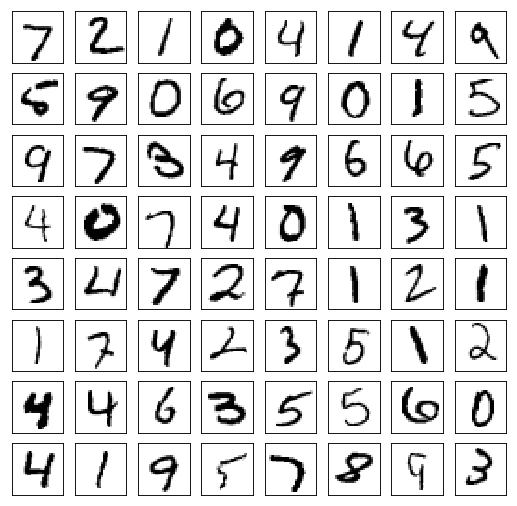

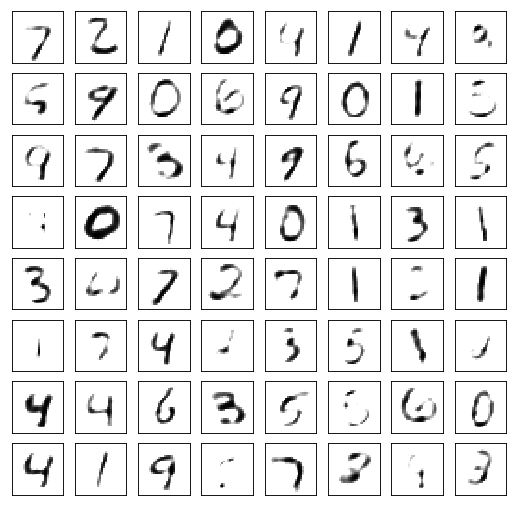

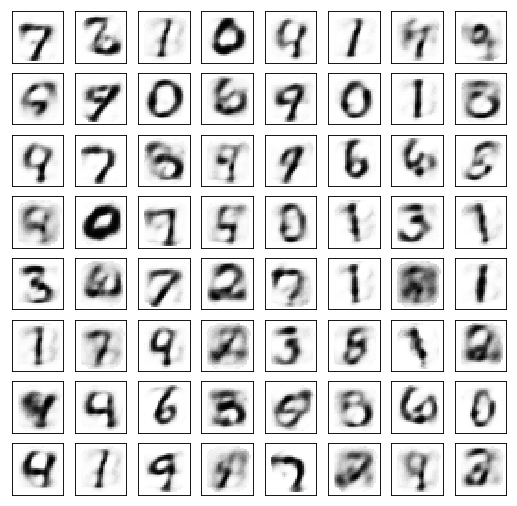

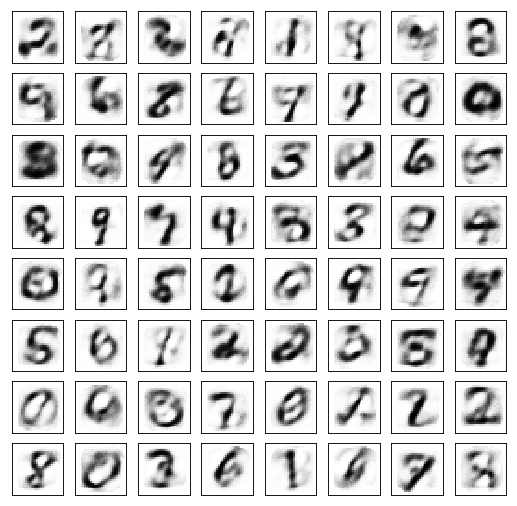

In [107]:
plot_mnist(data.data.numpy(), (8, 8))
plot_mnist(to_plot, (8, 8))

plot_mnist(f_to_plot, (8, 8))
plot_mnist(dec_to_plot, (8, 8))

In [18]:
the_model = Net(64)
the_model.load_state_dict(torch.load('relu_64.pt'))


In [20]:
data, _ = next(iter(test_loader))
output = the_model(data)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
decoded = the_model.decode(torch.eye(64))
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()
with torch.no_grad():
    encoded = the_model.E(data.view(-1, 28*28))
    print((encoded > 0.2).sum(1))
    encoded[encoded < 0.2] = 0.
    decoded_f = the_model.decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

tensor([  5,   5,   3,   7,   7,   5,   4,   6,   8,   5,   7,   4,
          5,   5,   4,   4,   6,   8,   4,   3,   5,   6,   8,   5,
          3,   6,   7,   5,   5,   5,   4,   5,   6,   4,   5,   6,
          5,   5,   0,   5,   4,   2,   5,   1,   4,   4,   7,   3,
          5,   7,   5,   5,   7,   6,  10,   5,   9,   3,   5,   2,
         10,   3,   2,   4])


(64, 1, 28, 28)


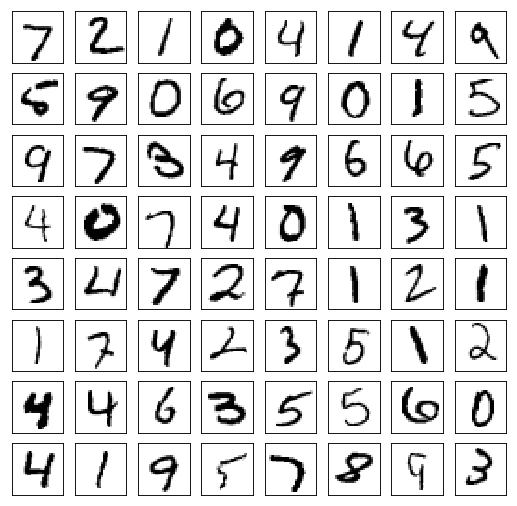

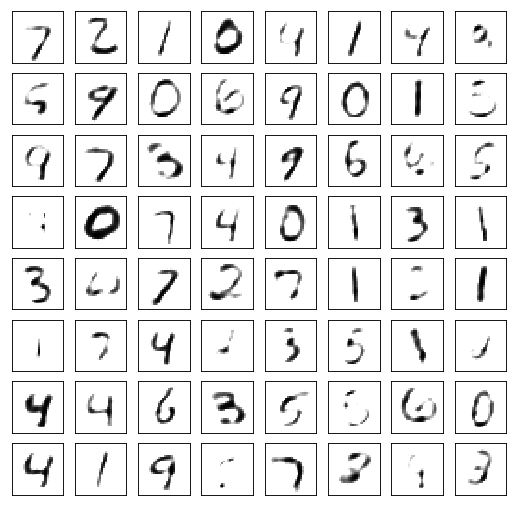

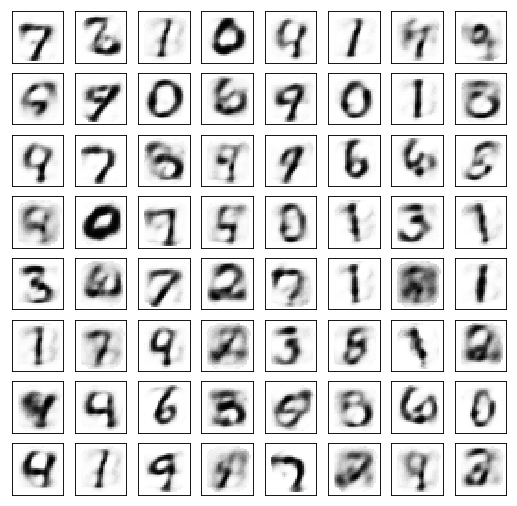

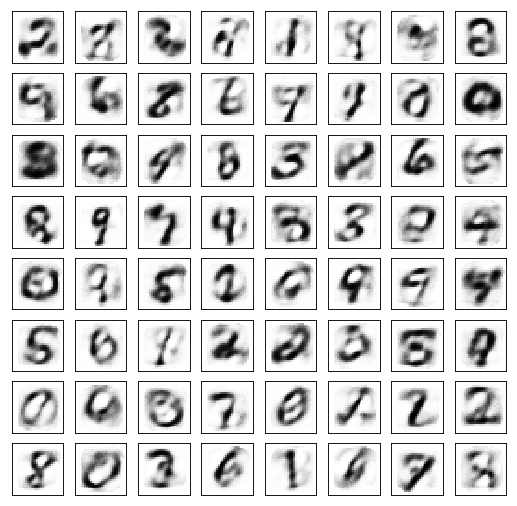

In [21]:
print(dec_to_plot.shape)

plot_mnist(data.data.numpy(), (8, 8))
plot_mnist(to_plot, (8, 8))

plot_mnist(f_to_plot, (8, 8))
plot_mnist(dec_to_plot, (8, 8))

In [120]:
w, _ = next(iter(test_loader))

In [121]:
w = nn.Parameter(w)
w_optim = optim.Adam(params=[w], lr=1e-1)

In [122]:
t = the_model.E(w.view(-1, 28*28))

In [123]:
for epoch in range(1, 1000):
    w_optim.zero_grad()
    t = the_model.E(w.view(-1, 28*28))    
    loss = F.mse_loss(t, torch.eye(64))
    loss.backward()
    w_optim.step()
    print(loss.item())

0.027321362867951393
0.018386732786893845
0.015393556095659733
0.014151742681860924
0.01333953533321619
0.012579504400491714
0.01187902968376875
0.011264310218393803
0.010653707198798656
0.010040845721960068
0.009454930201172829
0.008824965916574001
0.008134907111525536
0.0074774594977498055
0.00691963592544198
0.006473270244896412
0.006114803720265627
0.00581882381811738
0.005565611179918051
0.0053665172308683395
0.00521259568631649
0.005031303036957979
0.004839921370148659
0.004677305929362774
0.004542347975075245
0.0044012051075696945
0.0042724390514194965
0.004152084235101938
0.004013389348983765
0.003883967874571681
0.003771549090743065
0.003662500996142626
0.003552953014150262
0.0034568558912724257
0.0033486683387309313
0.0032031035516411066
0.0030562477186322212
0.0029413895681500435
0.0028143683448433876
0.002658731769770384
0.002512241480872035
0.002390641253441572
0.0023403349332511425
0.0023385335225611925
0.002340502105653286
0.002331649651750922
0.0023148618638515472
0.002

0.0004912923905067146
0.0004912839503958821
0.0004912744043394923
0.0004912661388516426
0.0004912562435492873
0.0004912475124001503
0.0004912384320050478
0.0004912287113256752
0.0004912199801765382
0.0004912109579890966
0.0004912024596706033
0.0004911937285214663
0.0004911847645416856
0.0004911763244308531
0.0004911682335659862
0.000491159618832171
0.0004911509458906949
0.0004911419237032533
0.000491133367177099
0.0004911253345198929
0.0004911168944090605
0.0004911082796752453
0.0004910999559797347
0.0004910921561531723
0.0004910839488729835
0.0004910758580081165
0.0004910678253509104
0.0004910603747703135
0.0004910526913590729
0.0004910438437946141
0.0004910360439680517
0.0004910283023491502
0.0004910202114842832
0.0004910127609036863
0.0004910045536234975
0.0004909969284199178
0.0004909894778393209
0.0004909820854663849
0.0004909743438474834
0.0004909670096822083
0.0004909596173092723
0.0004909519338980317
0.0004909445415250957
0.0004909365088678896
0.0004909295821562409
0.0004909223

0.0002455026260577142
0.00024549884255975485
0.00024549575755372643
0.0002454924979247153
0.00024548883084207773
0.00024548551300540566
0.0002454827481415123
0.00024547975044697523
0.00024547672364860773
0.0002454738423693925
0.000245470815571025
0.00024546770146116614
0.0002454648201819509
0.0002454617933835834
0.00024545908672735095
0.00024545626365579665
0.0002454534114804119
0.0002454507048241794
0.00024544805637560785
0.00024544523330405354
0.00024544235202483833
0.0002454394707456231
0.0002454370551276952
0.0002454342902638018
0.00024543149629607797
0.00024542867322452366
0.00024542593746446073
0.00024542323080822825
0.000245420727878809
0.0002454180212225765
0.0002454152563586831
0.0002454126952216029
0.00024540998856537044
0.00024540728190913796
0.0002454049536027014
0.00024540230515412986
0.00024539994774386287
0.00024539727019146085
0.0002453948254697025
0.00024539243895560503
0.0002453898196108639
0.0002453870256431401
0.00024538469733670354
0.00024538172874599695
0.00024537

In [124]:
res = the_model.E(w.view(-1, 28*28))    
for i in range(0, 64):
    print(res[i][i].item())

# print(torch.eye(64))
# print(res)
# print(torch.eye(64) - res)



0.9984424710273743
0.9963849782943726
0.9963873624801636
0.9962171912193298
0.9980759620666504
0.9957613348960876
0.9959869980812073
0.9964166879653931
0.9969612956047058
0.9960569143295288
0.9989457726478577
0.9955741167068481
0.9960195422172546
0.9950516819953918
0.9968878626823425
0.9990319013595581
0.9990457892417908
0.9969449639320374
0.9998024106025696
0.9955744743347168
0.9952253103256226
0.9965967535972595
0.9952670335769653
0.9994674324989319
0.9972003698348999
0.9934641718864441
0.9958059787750244
0.9960118532180786
0.9991263747215271
0.9960458874702454
0.999024510383606
0.9970622658729553
0.9977834820747375
0.9959896206855774
0.9965313076972961
0.9959607720375061
0.9960504174232483
0.9992069602012634
0.9965319633483887
0.9979730248451233
0.9980175495147705
0.9959004521369934
0.9995515942573547
0.9966959953308105
0.9963770508766174
0.9966450333595276
0.99724942445755
0.9987789988517761
0.9956996440887451
0.99610435962677
0.9976740479469299
0.9960240125656128
0.995736598968505

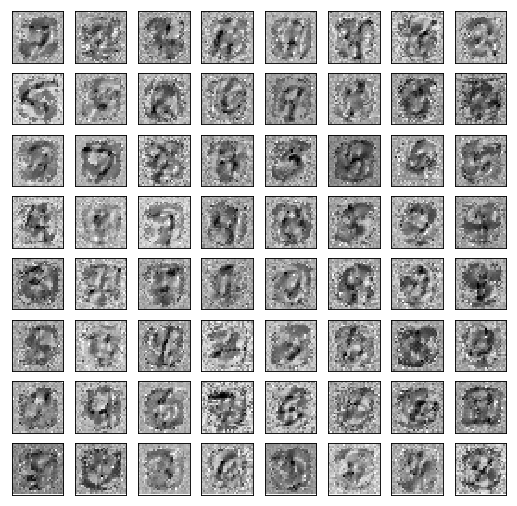

In [125]:
plot_mnist(w.data.numpy(), (8, 8))
